<a href="https://colab.research.google.com/github/mithilgotarne/Convolutional-Neural-Networks/blob/master/cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
################################################################################
#
# xNNs_Code_02_Vision_Class_CIFAR.py
#
# DESCRIPTION
#
#    TensorFlow CIFAR example
#
# INSTRUCTIONS
#
#    1. Go to Google Colaboratory: https://colab.research.google.com/notebooks/welcome.ipynb
#    2. File - New Python 3 notebook
#    3. Cut and paste this file into the cell (feel free to divide into multiple cells)
#    4. Runtime - Change runtime type - Hardware accelerator - GPU
#    5. Runtime - Run all
#
################################################################################


In [0]:
################################################################################
#
# IMPORT
#
################################################################################

# tenorflow
import tensorflow         as     tf
from   tensorflow         import keras
from   tensorflow         import contrib
from   tensorflow.contrib import autograph

# additional libraries
import numpy             as np
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
################################################################################
#
# PARAMETERS
#
################################################################################

# data
DATA_NUM_CLASSES = 10

# model
MODEL_LEVEL_0_BLOCKS = 4
MODEL_LEVEL_1_BLOCKS = 6
MODEL_LEVEL_2_BLOCKS = 3

# inception
INCEPTION_A_BLOCKS = 3
INCEPTION_B_BLOCKS = 4

# training
TRAINING_IMAGE_SIZE        = 32
TRAINING_ZERO_PADDED_SIZE  = 40
TRAINING_SHUFFLE_BUFFER    = 5000
TRAINING_BATCH_SIZE        = 32
TRAINING_NUM_EPOCHS        = 112
TRAINING_MOMENTUM          = 0.9                    # currently not used
TRAINING_REGULARIZER_SCALE = 0.1                    # currently not used
TRAINING_LR_INITIAL        = 0.001
TRAINING_LR_SCALE          = 0.1
TRAINING_LR_EPOCHS         = 48
TRAINING_LR_STAIRCASE      = True
TRAINING_MAX_CHECKPOINTS   = 5
TRAINING_CHECKPOINT_FILE   = './logs/model_{}.ckpt' # currently not used

In [0]:
################################################################################
#
# PRE PROCESSING
#
################################################################################

def pre_processing_train(image, label):

    # note: this function operates on 8 bit data then normalizes to a float

    # add a boarder of 0s
    image = tf.image.resize_image_with_crop_or_pad(image, TRAINING_ZERO_PADDED_SIZE, TRAINING_ZERO_PADDED_SIZE)

    # random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # random hue, contrast, brightness and saturation
    # image = tf.image.random_hue(image, max_delta=0.05)
    # image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    # image = tf.image.random_brightness(image, max_delta=0.2)
    # image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
    
    # random crop back to original size
    image = tf.random_crop(image, size=[TRAINING_IMAGE_SIZE, TRAINING_IMAGE_SIZE, 3])

    # normalization
    image = (tf.cast(image, tf.float32) - data_mean)/data_std
    
    return image, label

def pre_processing_test(image, label):
    
    # note: this function operates on 8 bit data then normalizes to a float
    
    # normalization
    image = (tf.cast(image, tf.float32) - data_mean)/data_std
    
    return image, label


In [0]:
################################################################################
#
# DATASET
#
################################################################################

# download
cifar10 = keras.datasets.cifar10

# training and testing split
(data_train, labels_train), (data_test, labels_test) = cifar10.load_data()

# normalization values
data_mean = np.mean(data_train, dtype=np.float32)
data_std  = np.std(data_train, dtype=np.float32)

# label typecast
labels_train = labels_train.astype(np.int32)
labels_test  = labels_test.astype(np.int32)
labels_train = np.squeeze(labels_train)
labels_test  = np.squeeze(labels_test)

# dataset
dataset_train = tf.data.Dataset.from_tensor_slices((data_train, labels_train))
dataset_test  = tf.data.Dataset.from_tensor_slices((data_test,  labels_test))

# transformation
dataset_train = dataset_train.shuffle(TRAINING_SHUFFLE_BUFFER).repeat().map(pre_processing_train).batch(TRAINING_BATCH_SIZE)
dataset_test  = dataset_test.repeat().map(pre_processing_test).batch(TRAINING_BATCH_SIZE)

# display
# print(data_train.shape)
# print(data_test.shape)
# print(labels_train.shape)
# print(labels_test.shape)


In [0]:
################################################################################
#
# ITERATOR
#
################################################################################

# iterator
iterator            = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)
iterator_init_train = iterator.make_initializer(dataset_train)
iterator_init_test  = iterator.make_initializer(dataset_test)

# example
# data.shape   = TRAINING_BATCH_SIZE x rows x cols
# labels.shape = TRAINING_BATCH_SIZE x 1
data, labels = iterator.get_next()



In [0]:
################################################################################
#
# MODEL - SEQUENTIAL
#
################################################################################

# sequential model
def model_sequential(data, train_state, num_classes):
    
    # data
    # TRAINING_BATCH_SIZE x rows x cols x channels
    
    # encoder - level 0
    fm       = tf.layers.conv2d(data, 32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    fm       = tf.layers.conv2d(fm,   32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    fm       = tf.layers.conv2d(fm,   32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    
    # encoder - level 1 down sampling
    fm       = tf.layers.max_pooling2d(fm, (3, 3), (2, 2), padding='same', data_format='channels_last')
    
    # encoder - level 1
    fm       = tf.layers.conv2d(fm,   64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    fm       = tf.layers.conv2d(fm,   64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    fm       = tf.layers.conv2d(fm,   64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    
    # encoder - level 2 down sampling
    fm       = tf.layers.max_pooling2d(fm, (3, 3), (2, 2), padding='same', data_format='channels_last')
    
    # encoder - level 2
    fm       = tf.layers.conv2d(fm,   128, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    fm       = tf.layers.conv2d(fm,   128, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    features = tf.layers.conv2d(fm,   128, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    
    # decoder
    # predictions.shape = TRAINING_BATCH_SIZE x num_classes
    features    = tf.reduce_mean(features, axis=[1, 2])
    predictions = tf.layers.dense(features, num_classes, activation=None, use_bias=True)
    
    # return
    return predictions


In [0]:

################################################################################
#
# MODEL - SEQUENTIAL BATCH NORM
#
################################################################################

# sequential batch norm model (85.25 %)
def model_sequential_bn(data, train_state, num_classes):
    
    # data
    # TRAINING_BATCH_SIZE x rows x cols x channels
    
    # encoder - level 0
    fm       = tf.layers.conv2d(data, 32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm       = tf.layers.batch_normalization(fm, training=train_state)
    fm       = tf.nn.relu(fm)
    fm       = tf.layers.conv2d(fm,   32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm       = tf.layers.batch_normalization(fm, training=train_state)
    fm       = tf.nn.relu(fm)
    fm       = tf.layers.conv2d(fm,   32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm       = tf.layers.batch_normalization(fm, training=train_state)
    fm       = tf.nn.relu(fm)

    # encoder - level 1 down sampling
    fm       = tf.layers.max_pooling2d(fm, (3, 3), (2, 2), padding='same', data_format='channels_last')
    
    # encoder - level 1
    fm       = tf.layers.conv2d(fm,   64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm       = tf.layers.batch_normalization(fm, training=train_state)
    fm       = tf.nn.relu(fm)
    fm       = tf.layers.conv2d(fm,   64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm       = tf.layers.batch_normalization(fm, training=train_state)
    fm       = tf.nn.relu(fm)
    fm       = tf.layers.conv2d(fm,   64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm       = tf.layers.batch_normalization(fm, training=train_state)
    fm       = tf.nn.relu(fm)
    
    # encoder - level 2 down sampling
    fm       = tf.layers.max_pooling2d(fm, (3, 3), (2, 2), padding='same', data_format='channels_last')

    # encoder - level 2
    fm       = tf.layers.conv2d(fm,   128, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm       = tf.layers.batch_normalization(fm, training=train_state)
    fm       = tf.nn.relu(fm)
    fm       = tf.layers.conv2d(fm,   128, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm       = tf.layers.batch_normalization(fm, training=train_state)
    fm       = tf.nn.relu(fm)
    fm       = tf.layers.conv2d(fm,   128, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm       = tf.layers.batch_normalization(fm, training=train_state)
    features = tf.nn.relu(fm)
    
    # decoder
    # predictions.shape = TRAINING_BATCH_SIZE x num_classes
    features    = tf.reduce_mean(features, axis=[1, 2])
    predictions = tf.layers.dense(features, num_classes, activation=None, use_bias=True)
    
    # return
    return predictions


In [0]:

################################################################################
#
# MODEL - RESNET V2
#
################################################################################

# resnet model (4-6-3 91.26 %)
@autograph.convert()
def model_resnet(data, train_state, level_0_blocks, level_1_blocks, level_2_blocks, num_classes):
    
    # data
    # TRAINING_BATCH_SIZE x rows x cols x channels

    # encoder - tail
    fm_id       = tf.layers.conv2d(data, 32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)

    # encoder - level 0 special bottleneck x1
    # input:  32 x 32 x 32
    # filter: 16 x 32 x 1 x 1 / 1
    # filter: 16 x 16 x 3 x 3
    # filter: 64 x 16 x 1 x 1
    # main:   64 x 32 x 1 x 1 / 1
    # output: 64 x 32 x 32
    fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 16, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 16, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 64, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.layers.conv2d(fm_id,       64, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.add(fm_id, fm_residual)

    # encoder - level 0 standard bottleneck x(level_0_blocks - 1)
    # input:  64 x 32 x 32
    # filter: 16 x 64 x 1 x 1
    # filter: 16 x 16 x 3 x 3
    # filter: 64 x 16 x 1 x 1
    # main:   identity
    # output: 64 x 32 x 32
    for block_repeat_0 in range(level_0_blocks - 1):
        fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 16, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 16, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 64, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_id       = tf.add(fm_id, fm_residual)

    # encoder - level 1 down sampling bottleneck x1
    # input:   64 x 32 x 32
    # filter:  32 x 64 x 1 x 1 / 2
    # filter:  32 x 32 x 3 x 3
    # filter: 128 x 32 x 1 x 1
    # main:   128 x 64 x 1 x 1 / 2
    # output: 128 x 16 x 16
    fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual,  32, (1, 1), strides=(2, 2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual,  32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 128, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.layers.conv2d(fm_id,       128, (1, 1), strides=(2, 2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.add(fm_id, fm_residual)

    # encoder - level 1 standard bottleneck x(level_1_blocks - 1)
    # input:  128 x  16 x 16
    # filter:  32 x 128 x 1 x 1
    # filter:  32 x  32 x 3 x 3
    # filter: 128 x  32 x 1 x 1
    # main:   identity
    # output: 128 x  16 x 16
    for block_repeat_1 in range(level_1_blocks - 1):
        fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual,  32, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual,  32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 128, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_id       = tf.add(fm_id, fm_residual)
    
    # encoder - level 2 down sampling bottleneck x1
    # input:  128 x  16 x 16
    # filter:  64 x 128 x 1 x 1 / 2
    # filter:  64 x  64 x 3 x 3
    # filter: 256 x  64 x 1 x 1
    # main:   256 x 128 x 1 x 1 / 2
    # output: 256 x   8 x 8
    fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual,  64, (1, 1), strides=(2, 2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual,  64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 256, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.layers.conv2d(fm_id,       256, (1, 1), strides=(2, 2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.add(fm_id, fm_residual)

    # encoder - level 2 standard bottleneck x(level_2_blocks - 1)
    # input:  256 x   8 x 8
    # filter:  64 x 256 x 1 x 1
    # filter:  64 x  64 x 3 x 3
    # filter: 256 x  64 x 1 x 1
    # main:   identity
    # output: 256 x   8 x 8
    for block_repeat_2 in range(level_2_blocks - 1):
        fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual,  64, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual,  64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 256, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_id       = tf.add(fm_id, fm_residual)
    
    # encoder - level 2 special block x1
    # input:  256 x   8 x 8
    # output: 256 x   8 x 8
    fm_id       = tf.layers.batch_normalization(fm_id, training=train_state)
    fm_id       = tf.nn.relu(fm_id)

    # decoder
    # predictions.shape = TRAINING_BATCH_SIZE x num_classes
    fm_id       = tf.reduce_mean(fm_id, axis=[1, 2])
    predictions = tf.layers.dense(fm_id, num_classes, activation=None, use_bias=True)
    
    # return
    return predictions


In [0]:

################################################################################
#
# MODEL - RESNET V2 HALF WIDE
#
################################################################################

# resnet model half wide (4-6-3  %)
@autograph.convert()
def model_resnet_halfwide(data, train_state, level_0_blocks, level_1_blocks, level_2_blocks, num_classes):
    
    # data
    # TRAINING_BATCH_SIZE x rows x cols x channels

    # encoder - tail
    fm_id       = tf.layers.conv2d(data, 16, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)

    # encoder - level 0 special bottleneck x1
    # input:  16 x 32 x 32
    # filter: 8 x 16 x 1 x 1 / 1
    # filter: 8 x 8 x 3 x 3
    # filter: 32 x 8 x 1 x 1
    # main:   32 x 16 x 1 x 1 / 1
    # output: 32 x 32 x 32
    fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 8, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 8, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 32, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.layers.conv2d(fm_id,       32, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.add(fm_id, fm_residual)

    # encoder - level 0 standard bottleneck x(level_0_blocks - 1)
    # input:  32 x 32 x 32
    # filter: 8 x 32 x 1 x 1
    # filter: 8 x 8 x 3 x 3
    # filter: 32 x 8 x 1 x 1
    # main:   identity
    # output: 32 x 32 x 32
    for block_repeat_0 in range(level_0_blocks - 1):
        fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 8, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 8, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 32, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_id       = tf.add(fm_id, fm_residual)

    # encoder - level 1 down sampling bottleneck x1
    # input:   32 x 32 x 32
    # filter:  16 x 32 x 1 x 1 / 2
    # filter:  16 x 16 x 3 x 3
    # filter:  64 x 16 x 1 x 1
    # main:    64 x 32 x 1 x 1 / 2
    # output:  64 x 16 x 16
    fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual,  16, (1, 1), strides=(2, 2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual,  16, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 64, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.layers.conv2d(fm_id,       64, (1, 1), strides=(2, 2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.add(fm_id, fm_residual)

    # encoder - level 1 standard bottleneck x(level_1_blocks - 1)
    # input:  64 x  16 x 16
    # filter: 16 x 64 x 1 x 1
    # filter:  16 x  16 x 3 x 3
    # filter: 64 x  16 x 1 x 1
    # main:   identity
    # output: 64 x  16 x 16
    for block_repeat_1 in range(level_1_blocks - 1):
        fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual,  16, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual,  16, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 64, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_id       = tf.add(fm_id, fm_residual)
    
    # encoder - level 2 down sampling bottleneck x1
    # input:  64 x  16 x 16
    # filter:  32 x 64 x 1 x 1 / 2
    # filter:  32 x  32 x 3 x 3
    # filter: 128 x  32 x 1 x 1
    # main:   128 x 64 x 1 x 1 / 2
    # output: 128 x   8 x 8
    fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual,  32, (1, 1), strides=(2, 2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual,  32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
    fm_residual = tf.nn.relu(fm_residual)
    fm_residual = tf.layers.conv2d(fm_residual, 128, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.layers.conv2d(fm_id,       128, (1, 1), strides=(2, 2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    fm_id       = tf.add(fm_id, fm_residual)

    # encoder - level 2 standard bottleneck x(level_2_blocks - 1)
    # input:  128 x   8 x 8
    # filter:  32 x 128 x 1 x 1
    # filter:  32 x  32 x 3 x 3
    # filter: 128 x  32 x 1 x 1
    # main:   identity
    # output: 128 x   8 x 8
    for block_repeat_2 in range(level_2_blocks - 1):
        fm_residual = tf.layers.batch_normalization(fm_id, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual,  32, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual,  32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_residual = tf.layers.batch_normalization(fm_residual, training=train_state)
        fm_residual = tf.nn.relu(fm_residual)
        fm_residual = tf.layers.conv2d(fm_residual, 128, (1, 1), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        fm_id       = tf.add(fm_id, fm_residual)
    
    # encoder - level 2 special block x1
    # input:  128 x   8 x 8
    # output: 128 x   8 x 8
    fm_id       = tf.layers.batch_normalization(fm_id, training=train_state)
    fm_id       = tf.nn.relu(fm_id)

    # decoder
    # predictions.shape = TRAINING_BATCH_SIZE x num_classes
    fm_id       = tf.reduce_mean(fm_id, axis=[1, 2])
    predictions = tf.layers.dense(fm_id, num_classes, activation=None, use_bias=True)
    
    # return
    return predictions


In [0]:
import time
start_time = time.time()

################################################################################
#
# TRAINING RESNET v2
#
################################################################################

# state
train_state = tf.placeholder(tf.bool, name='train_state')

# data
num_train         = len(data_train)
num_test          = len(data_test)
num_batches_train = int(num_train/TRAINING_BATCH_SIZE)
num_batches_test  = int(num_test/TRAINING_BATCH_SIZE)

# display
# print(num_train)
# print(num_test)
# print(num_batches_train)
# print(num_batches_test)

# model
# predictions      = model_sequential(data, train_state, DATA_NUM_CLASSES)
# predictions      = model_sequential_bn(data, train_state, DATA_NUM_CLASSES)
predictions      = model_resnet(data, train_state, MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS, DATA_NUM_CLASSES)
#predictions      = model_resnet_halfwide(data, train_state, MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS, DATA_NUM_CLASSES)


predictions_test = np.zeros((num_test, DATA_NUM_CLASSES), dtype=np.float32)

# accuracy
accuracy = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(predictions, 1), tf.cast(labels, tf.int64)), tf.float32))

# loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=predictions)

# optimizer
global_step   = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(TRAINING_LR_INITIAL, global_step, TRAINING_LR_EPOCHS*num_batches_train, TRAINING_LR_SCALE, staircase=TRAINING_LR_STAIRCASE)
update_ops    = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    # optimizer = tf.train.MomentumOptimizer(learning_rate, TRAINING_MOMENTUM, use_nesterov=True).minimize(loss, global_step=global_step)

# saver
# saver = tf.train.Saver(max_to_keep=TRAINING_MAX_CHECKPOINTS)

# create a session
session = tf.Session()
    
# initialize global variables
session.run(tf.global_variables_initializer())

# cycle through the epochs
for epoch_index in range(TRAINING_NUM_EPOCHS):
    
    # train
    # initialize the iterator to the training dataset
    # cycle through the training batches
    # example, encoder, decoder, error, gradient computation and update
    session.run(iterator_init_train)
    for batch_index in range(num_batches_train):
        session.run(optimizer, feed_dict={train_state: True})

    # validate
    # initialize the iterator to the testing dataset
    # reset the accuracy statistics
    # cycle through the testing batches
    # example, encoder, decoder, accuracy
    session.run(iterator_init_test)
    num_correct = 0
    for batch_index in range(num_batches_test):
        num_correct_batch, predictions_batch    = session.run([accuracy, predictions], feed_dict={train_state: False})
        num_correct                            += num_correct_batch
        row_start                               = batch_index*TRAINING_BATCH_SIZE
        row_end                                 = (batch_index + 1)*TRAINING_BATCH_SIZE
        predictions_test[row_start:row_end, :]  = predictions_batch

    # display
    print('Epoch {0:3d}: top 1 accuracy on the test set is {1:5.2f} %'.format(epoch_index, (100.0*num_correct)/(TRAINING_BATCH_SIZE*num_batches_test)))

    # save
    # saver.save(session, TRAINING_CHECKPOINT_FILE.format(epoch_index))

# close the session
session.close()

print("TRAINING RESNET v2--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch   0: top 1 accuracy on the test set is 31.50 %
Epoch   1: top 1 accuracy on the test set is 44.80 %
Epoch   2: top 1 accuracy on the test set is 61.10 %
Epoch   3: top 1 accuracy on the test set is 68.77 %
TRAINING RESNET v2--- 361.62019324302673 seconds ---


Predicted label: 3 and actual label: 3


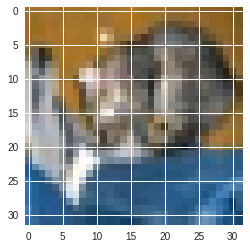

Predicted label: 8 and actual label: 8


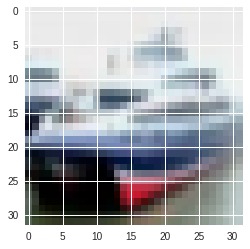

Predicted label: 8 and actual label: 8


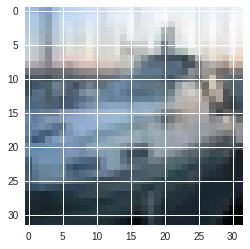

Predicted label: 0 and actual label: 0


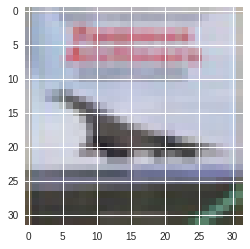

Predicted label: 6 and actual label: 6


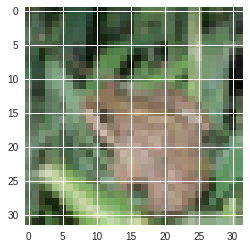

Predicted label: 6 and actual label: 6


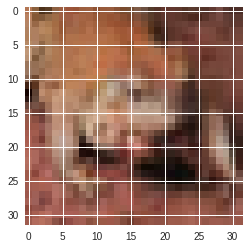

Predicted label: 3 and actual label: 1


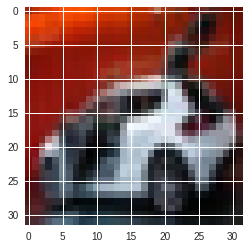

Predicted label: 4 and actual label: 6


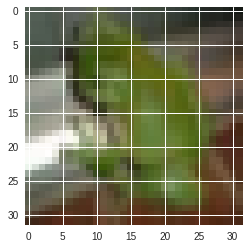

Predicted label: 5 and actual label: 3


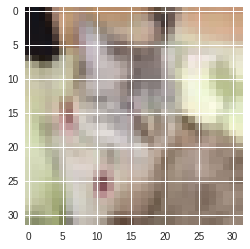

Predicted label: 0 and actual label: 1


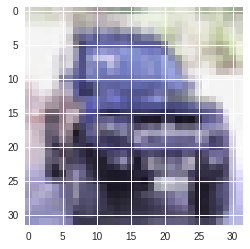

Predicted label: 0 and actual label: 0


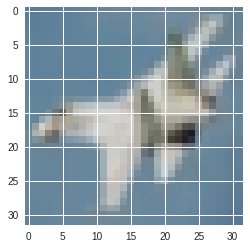

Predicted label: 9 and actual label: 9


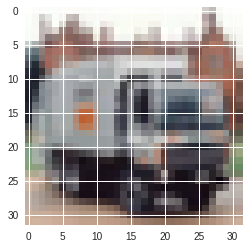

Predicted label: 5 and actual label: 5


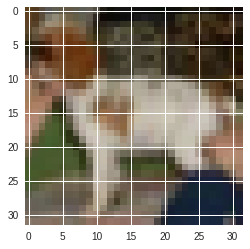

Predicted label: 5 and actual label: 7


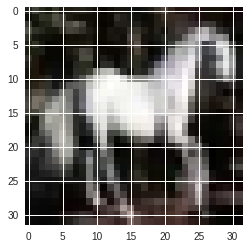

Predicted label: 9 and actual label: 9


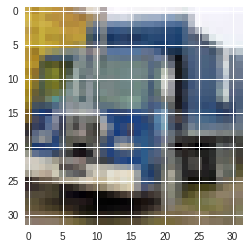

Predicted label: 8 and actual label: 8


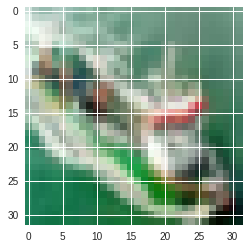

Predicted label: 5 and actual label: 5


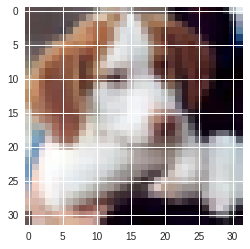

Predicted label: 5 and actual label: 7


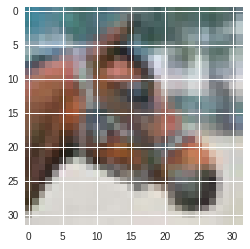

Predicted label: 8 and actual label: 8


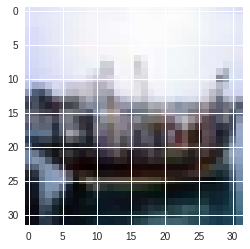

Predicted label: 6 and actual label: 6


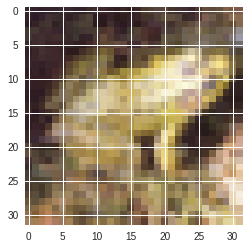

Predicted label: 7 and actual label: 7


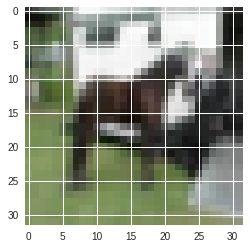

Predicted label: 0 and actual label: 0


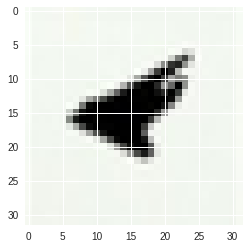

Predicted label: 4 and actual label: 4


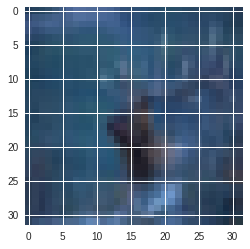

Predicted label: 9 and actual label: 9


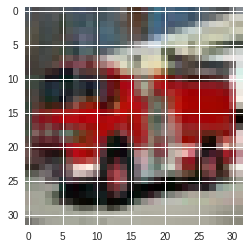

Predicted label: 4 and actual label: 5


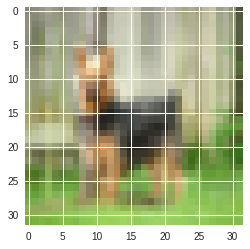

Predicted label: 5 and actual label: 2


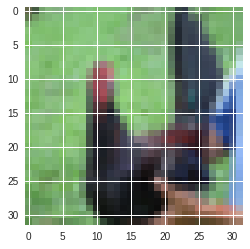

Predicted label: 4 and actual label: 4


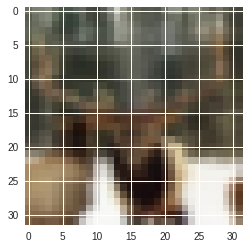

Predicted label: 0 and actual label: 0


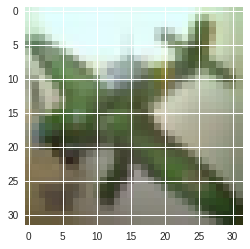

Predicted label: 9 and actual label: 9


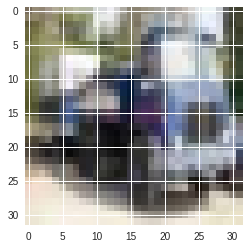

Predicted label: 6 and actual label: 6


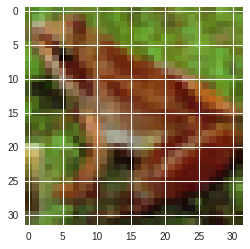

Predicted label: 6 and actual label: 6


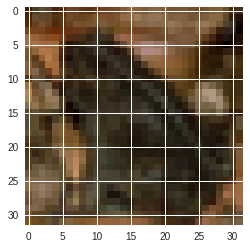

Predicted label: 5 and actual label: 5


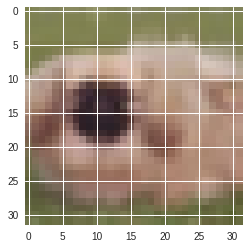

Predicted label: 4 and actual label: 4


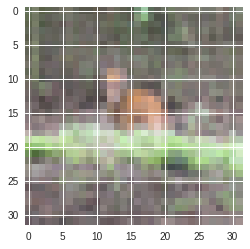

Predicted label: 5 and actual label: 5


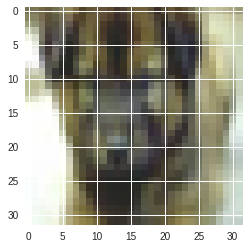

Predicted label: 9 and actual label: 9


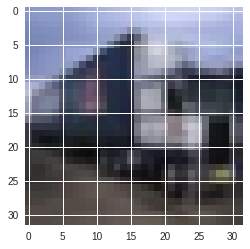

Predicted label: 3 and actual label: 2


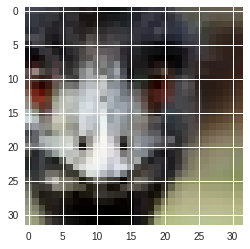

Predicted label: 4 and actual label: 4


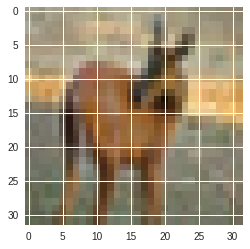

Predicted label: 8 and actual label: 1


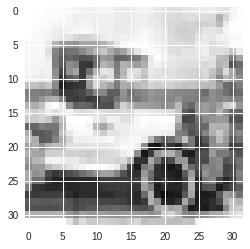

Predicted label: 9 and actual label: 9


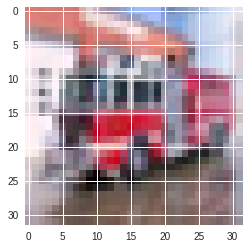

Predicted label: 5 and actual label: 5


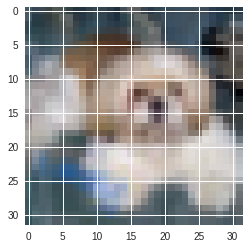

Predicted label: 0 and actual label: 4


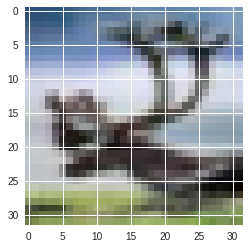

Predicted label: 6 and actual label: 6


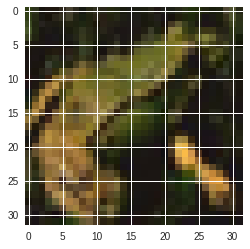

Predicted label: 5 and actual label: 5


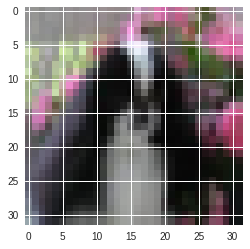

Predicted label: 6 and actual label: 6


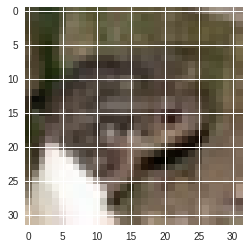

Predicted label: 0 and actual label: 0


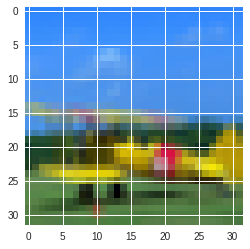

Predicted label: 9 and actual label: 9


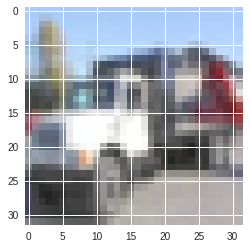

Predicted label: 3 and actual label: 3


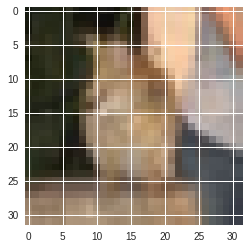

Predicted label: 9 and actual label: 9


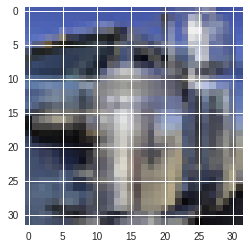

Predicted label: 4 and actual label: 7


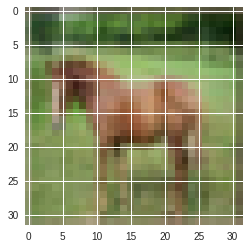

Predicted label: 4 and actual label: 6


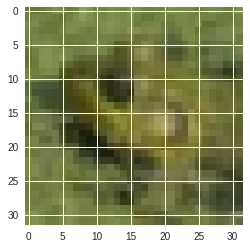

Predicted label: 0 and actual label: 9


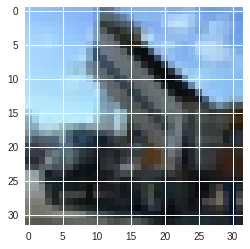

Predicted label: 8 and actual label: 8


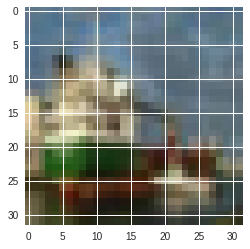

Predicted label: 2 and actual label: 0


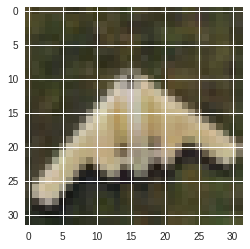

Predicted label: 6 and actual label: 3


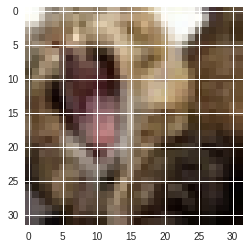

Predicted label: 8 and actual label: 8


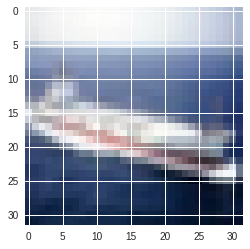

Predicted label: 8 and actual label: 8


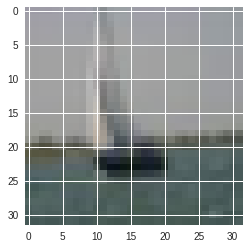

Predicted label: 5 and actual label: 7


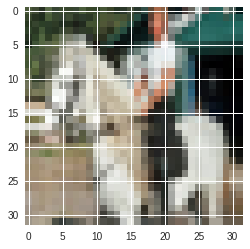

Predicted label: 5 and actual label: 7


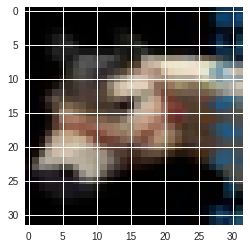

Predicted label: 3 and actual label: 4


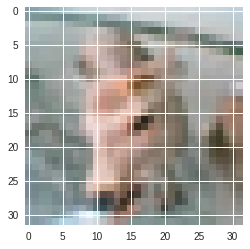

Predicted label: 3 and actual label: 6


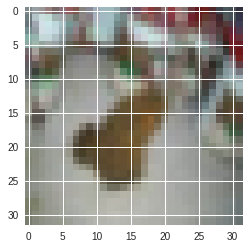

Predicted label: 4 and actual label: 7


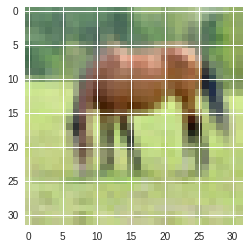

Predicted label: 5 and actual label: 3


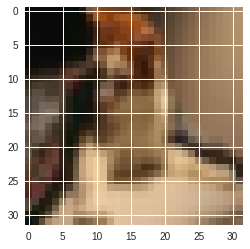

Predicted label: 6 and actual label: 6


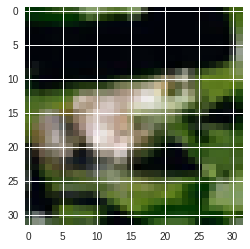

Predicted label: 0 and actual label: 3


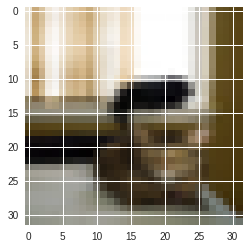

Predicted label: 3 and actual label: 6


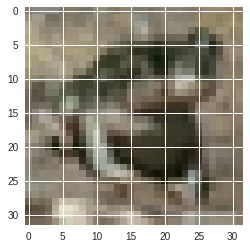

Predicted label: 2 and actual label: 2


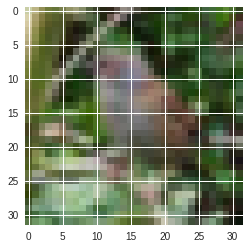

Predicted label: 1 and actual label: 1


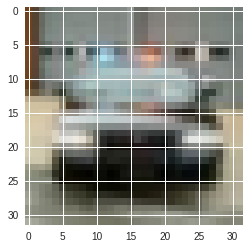

Predicted label: 2 and actual label: 2


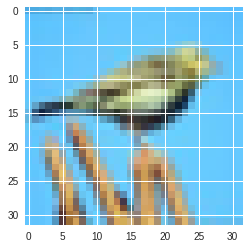

Predicted label: 3 and actual label: 3


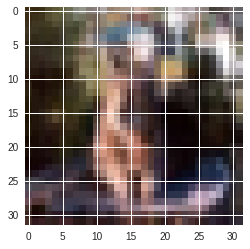

Predicted label: 4 and actual label: 7


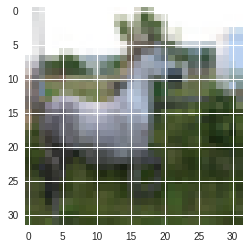

Predicted label: 0 and actual label: 2


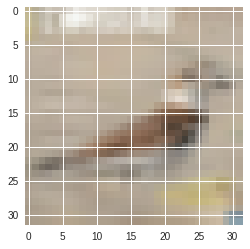

Predicted label: 3 and actual label: 6


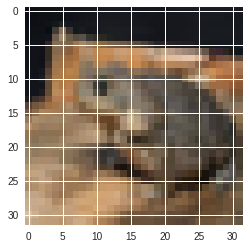

Predicted label: 8 and actual label: 8


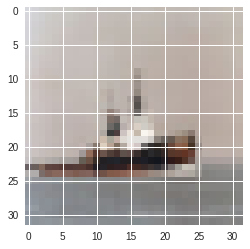

Predicted label: 8 and actual label: 8


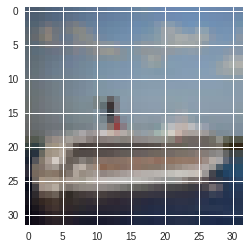

Predicted label: 0 and actual label: 0


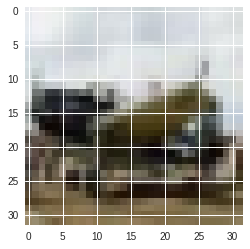

Predicted label: 2 and actual label: 2


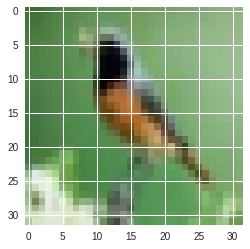

Predicted label: 0 and actual label: 9


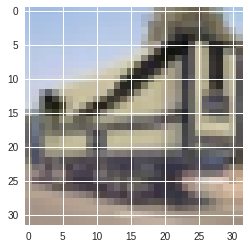

Predicted label: 3 and actual label: 3


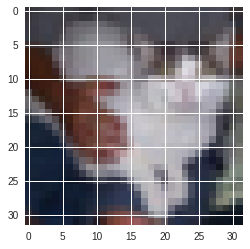

Predicted label: 5 and actual label: 3


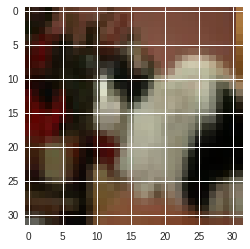

Predicted label: 8 and actual label: 8


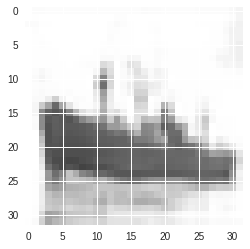

Predicted label: 8 and actual label: 8


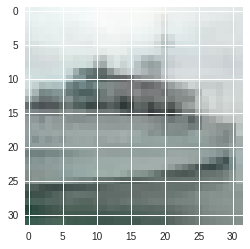

Predicted label: 1 and actual label: 1


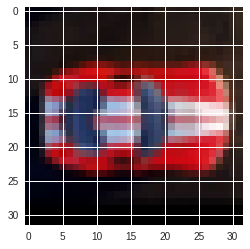

Predicted label: 1 and actual label: 1


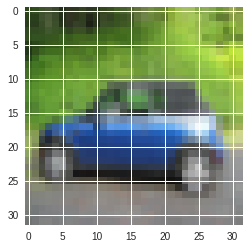

Predicted label: 7 and actual label: 7


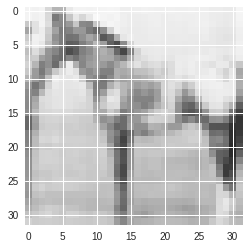

Predicted label: 2 and actual label: 2


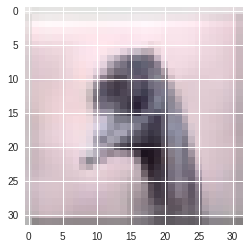

Predicted label: 5 and actual label: 5


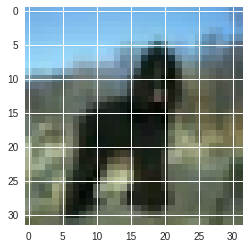

Predicted label: 2 and actual label: 2


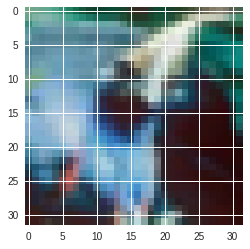

Predicted label: 2 and actual label: 7


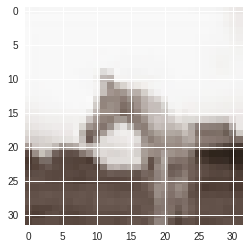

Predicted label: 8 and actual label: 8


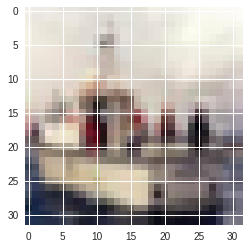

Predicted label: 9 and actual label: 9


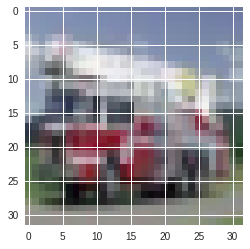

Predicted label: 0 and actual label: 0


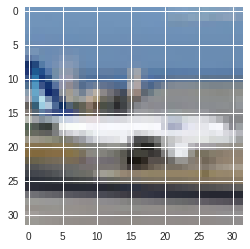

Predicted label: 2 and actual label: 3


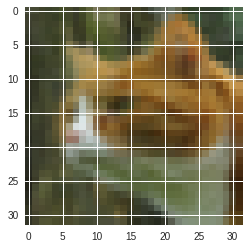

Predicted label: 8 and actual label: 8


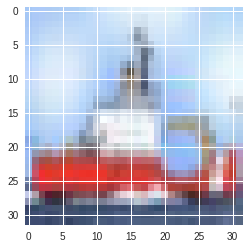

Predicted label: 6 and actual label: 6


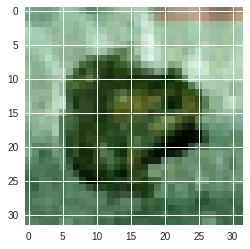

Predicted label: 4 and actual label: 4


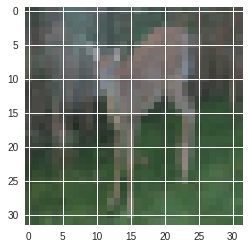

Predicted label: 6 and actual label: 6


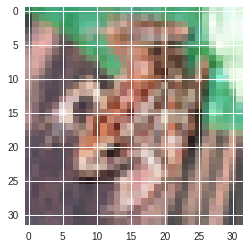

Predicted label: 6 and actual label: 6


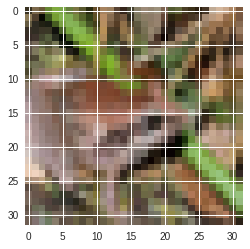

Predicted label: 2 and actual label: 0


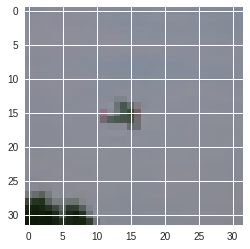

Predicted label: 0 and actual label: 0


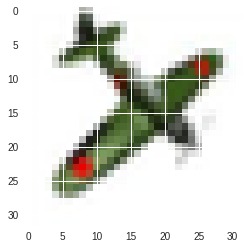

Predicted label: 5 and actual label: 7


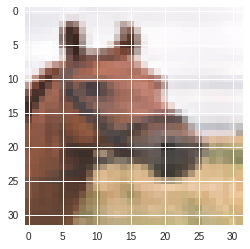

Predicted label: 4 and actual label: 4


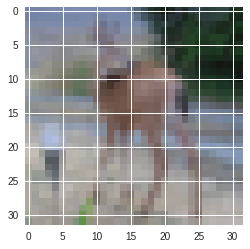

Predicted label: 4 and actual label: 5


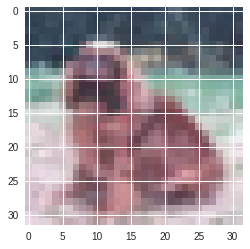

Predicted label: 6 and actual label: 6


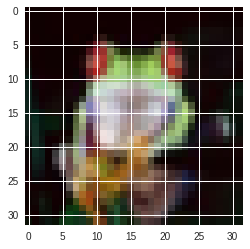

Predicted label: 6 and actual label: 3


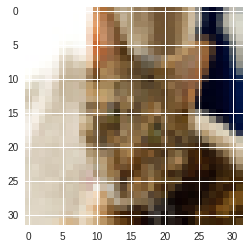

Predicted label: 1 and actual label: 1


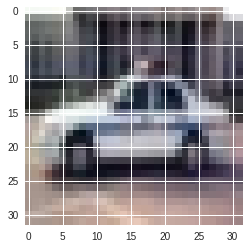

Predicted label: 1 and actual label: 1


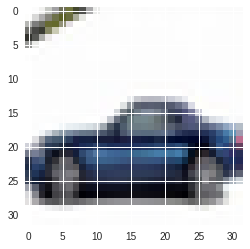

Predicted label: 3 and actual label: 3


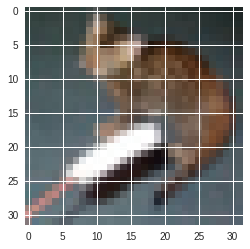

Predicted label: 6 and actual label: 6


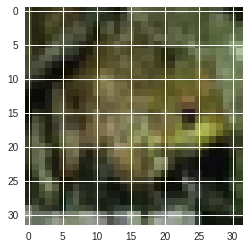

Predicted label: 8 and actual label: 8


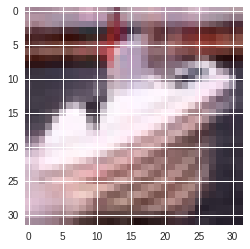

Predicted label: 5 and actual label: 7


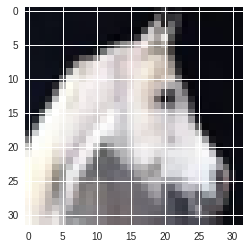

Predicted label: 6 and actual label: 4


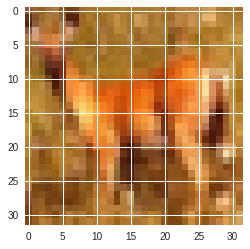

Predicted label: 0 and actual label: 0


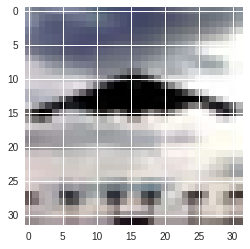

Predicted label: 2 and actual label: 6


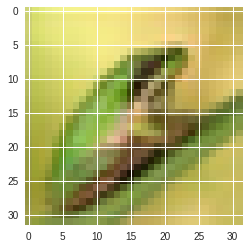

Predicted label: 2 and actual label: 2


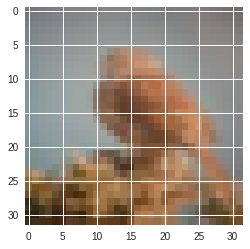

Predicted label: 1 and actual label: 1


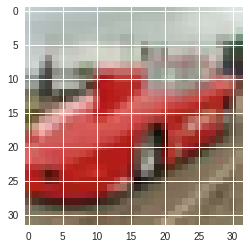

Predicted label: 3 and actual label: 3


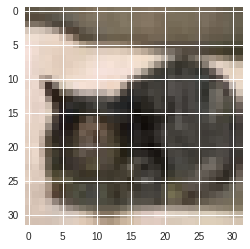

Predicted label: 0 and actual label: 0


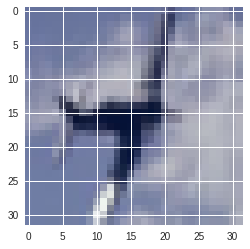

Predicted label: 4 and actual label: 4


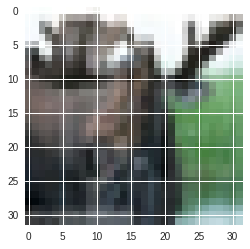

Predicted label: 6 and actual label: 2


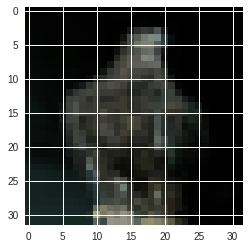

Predicted label: 7 and actual label: 7


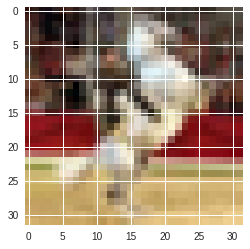

Predicted label: 8 and actual label: 8


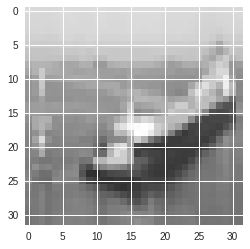

Predicted label: 3 and actual label: 3


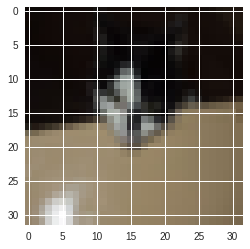

Predicted label: 1 and actual label: 1


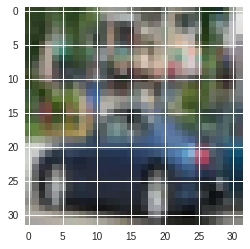

Predicted label: 2 and actual label: 2


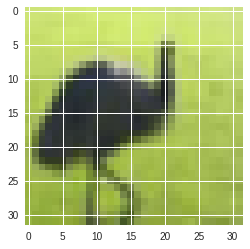

Predicted label: 0 and actual label: 8


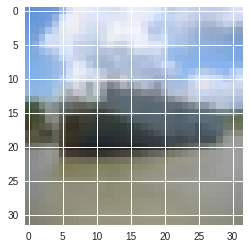

Predicted label: 0 and actual label: 0


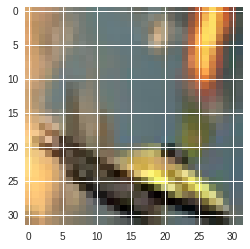

Predicted label: 8 and actual label: 8


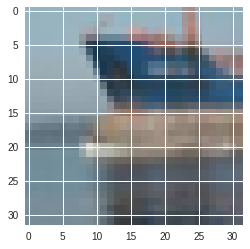

Predicted label: 3 and actual label: 3


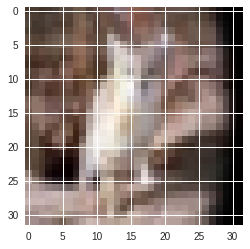

In [0]:

################################################################################
#
# DISPLAY
#
################################################################################

# create a session
session = tf.Session()

# initialize global variables
session.run(tf.global_variables_initializer())

# initialize the test iterator
session.run(iterator_init_test)

# cycle through a few batches
for batch_index in range(1):
    
    # generate data and labels
    data_batch, labels_batch = session.run([data, labels])
    
    # normalize to [0, 1]
    data_batch = ((data_batch*data_std) + data_mean)/255.0;
    
    # convert the final saved predictions to labels
    row_start          = batch_index*TRAINING_BATCH_SIZE
    row_end            = (batch_index + 1)*TRAINING_BATCH_SIZE
    predictions_labels = np.argmax(predictions_test[row_start:row_end, :], axis=1)
    
    # cycle through the images in the batch
    for image_index in range(TRAINING_BATCH_SIZE):
        
        # display the predicted label, actual label and image
        print('Predicted label: {0:1d} and actual label: {1:1d}'.format(predictions_labels[image_index], labels_batch[image_index]))
        plt.imshow(data_batch[image_index, :, :, :])
        plt.show()

# close the session
session.close()


In [0]:
import time
start_time = time.time()
################################################################################
#
# TRAINING RESNETv2 HALFWIDE
#
################################################################################

# state
train_state = tf.placeholder(tf.bool, name='train_state')

# data
num_train         = len(data_train)
num_test          = len(data_test)
num_batches_train = int(num_train/TRAINING_BATCH_SIZE)
num_batches_test  = int(num_test/TRAINING_BATCH_SIZE)

# display
# print(num_train)
# print(num_test)
# print(num_batches_train)
# print(num_batches_test)

# model
# predictions      = model_sequential(data, train_state, DATA_NUM_CLASSES)
# predictions      = model_sequential_bn(data, train_state, DATA_NUM_CLASSES)
# predictions      = model_resnet(data, train_state, MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS, DATA_NUM_CLASSES)
predictions      = model_resnet_halfwide(data, train_state, MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS, DATA_NUM_CLASSES)


predictions_test = np.zeros((num_test, DATA_NUM_CLASSES), dtype=np.float32)

# accuracy
accuracy = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(predictions, 1), tf.cast(labels, tf.int64)), tf.float32))

# loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=predictions)

# optimizer
global_step   = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(TRAINING_LR_INITIAL, global_step, TRAINING_LR_EPOCHS*num_batches_train, TRAINING_LR_SCALE, staircase=TRAINING_LR_STAIRCASE)
update_ops    = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    # optimizer = tf.train.MomentumOptimizer(learning_rate, TRAINING_MOMENTUM, use_nesterov=True).minimize(loss, global_step=global_step)

# saver
# saver = tf.train.Saver(max_to_keep=TRAINING_MAX_CHECKPOINTS)

# create a session
session = tf.Session()
    
# initialize global variables
session.run(tf.global_variables_initializer())

# cycle through the epochs
for epoch_index in range(TRAINING_NUM_EPOCHS):
    
    # train
    # initialize the iterator to the training dataset
    # cycle through the training batches
    # example, encoder, decoder, error, gradient computation and update
    session.run(iterator_init_train)
    for batch_index in range(num_batches_train):
        session.run(optimizer, feed_dict={train_state: True})

    # validate
    # initialize the iterator to the testing dataset
    # reset the accuracy statistics
    # cycle through the testing batches
    # example, encoder, decoder, accuracy
    session.run(iterator_init_test)
    num_correct = 0
    for batch_index in range(num_batches_test):
        num_correct_batch, predictions_batch    = session.run([accuracy, predictions], feed_dict={train_state: False})
        num_correct                            += num_correct_batch
        row_start                               = batch_index*TRAINING_BATCH_SIZE
        row_end                                 = (batch_index + 1)*TRAINING_BATCH_SIZE
        predictions_test[row_start:row_end, :]  = predictions_batch

    # display
    print('Epoch {0:3d}: top 1 accuracy on the test set is {1:5.2f} %'.format(epoch_index, (100.0*num_correct)/(TRAINING_BATCH_SIZE*num_batches_test)))

    # save
    # saver.save(session, TRAINING_CHECKPOINT_FILE.format(epoch_index))

# close the session
session.close()
print("TRAINING RESNETv2 HALFWIDE--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch   0: top 1 accuracy on the test set is 29.28 %
Epoch   1: top 1 accuracy on the test set is 55.71 %
Epoch   2: top 1 accuracy on the test set is 60.47 %
Epoch   3: top 1 accuracy on the test set is 45.09 %
TRAINING RESNETv2 HALFWIDE--- 234.36707067489624 seconds ---


Predicted label: 0 and actual label: 3


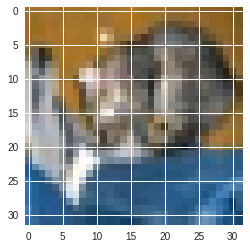

Predicted label: 1 and actual label: 8


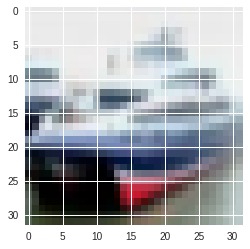

Predicted label: 1 and actual label: 8


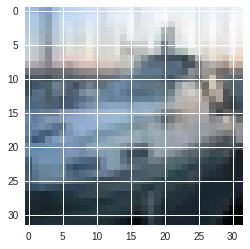

Predicted label: 1 and actual label: 0


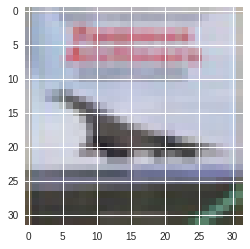

Predicted label: 6 and actual label: 6


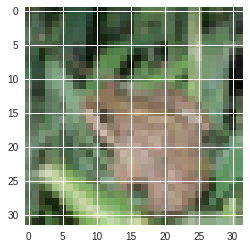

Predicted label: 6 and actual label: 6


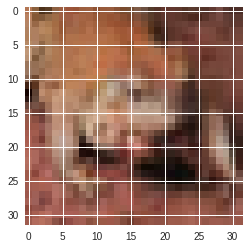

Predicted label: 1 and actual label: 1


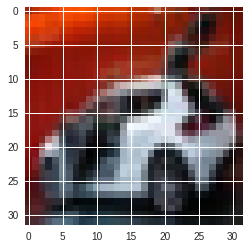

Predicted label: 2 and actual label: 6


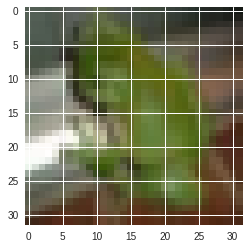

Predicted label: 7 and actual label: 3


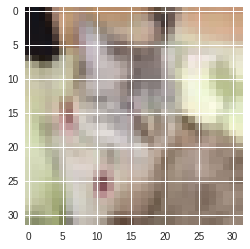

Predicted label: 1 and actual label: 1


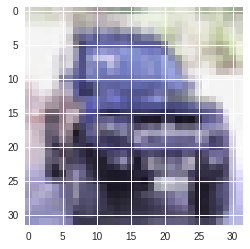

Predicted label: 0 and actual label: 0


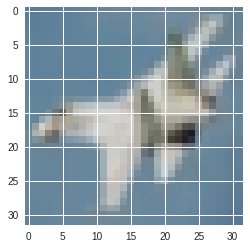

Predicted label: 9 and actual label: 9


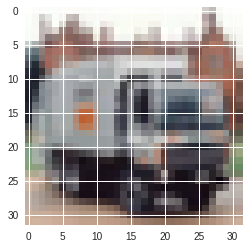

Predicted label: 7 and actual label: 5


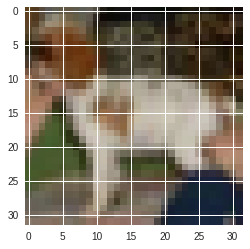

Predicted label: 7 and actual label: 7


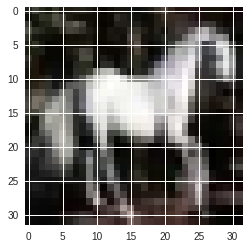

Predicted label: 1 and actual label: 9


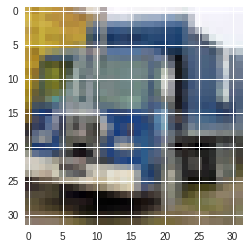

Predicted label: 8 and actual label: 8


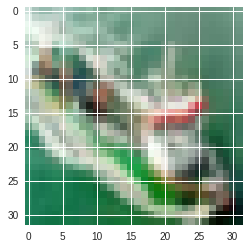

Predicted label: 7 and actual label: 5


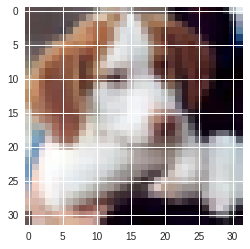

Predicted label: 7 and actual label: 7


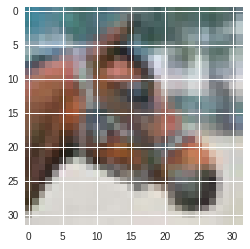

Predicted label: 8 and actual label: 8


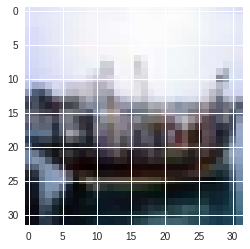

Predicted label: 2 and actual label: 6


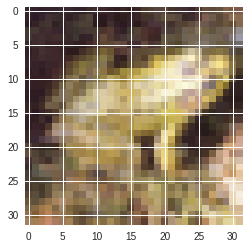

Predicted label: 7 and actual label: 7


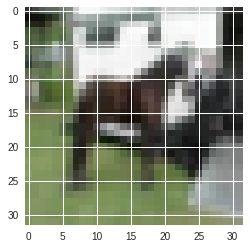

Predicted label: 0 and actual label: 0


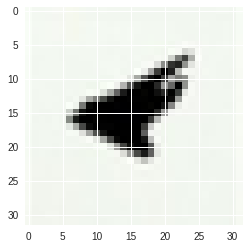

Predicted label: 0 and actual label: 4


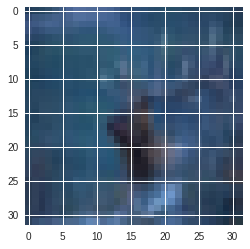

Predicted label: 9 and actual label: 9


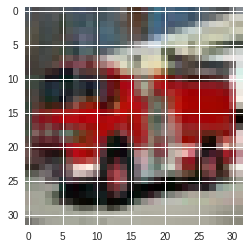

Predicted label: 4 and actual label: 5


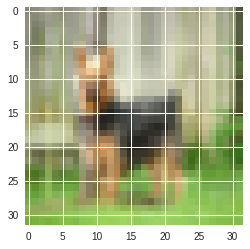

Predicted label: 2 and actual label: 2


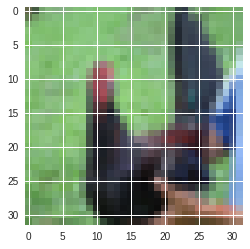

Predicted label: 2 and actual label: 4


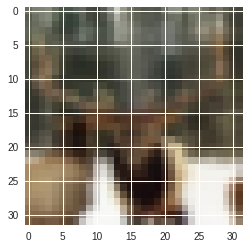

Predicted label: 0 and actual label: 0


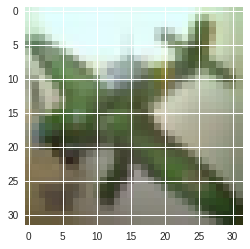

Predicted label: 9 and actual label: 9


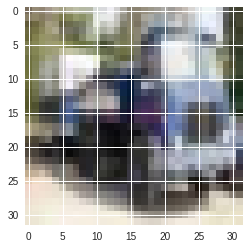

Predicted label: 2 and actual label: 6


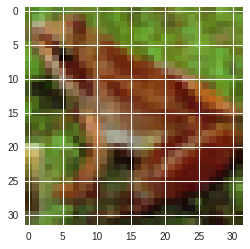

Predicted label: 9 and actual label: 6


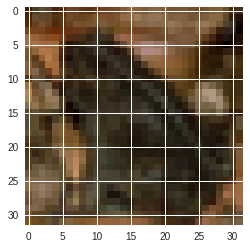

Predicted label: 7 and actual label: 5


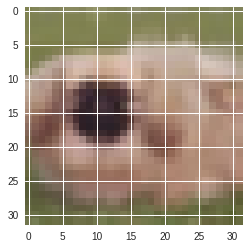

Predicted label: 2 and actual label: 4


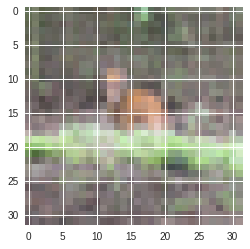

Predicted label: 3 and actual label: 5


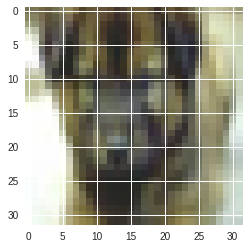

Predicted label: 9 and actual label: 9


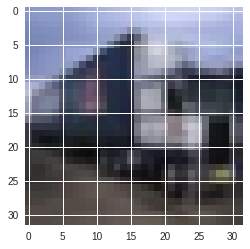

Predicted label: 1 and actual label: 2


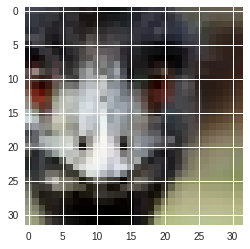

Predicted label: 7 and actual label: 4


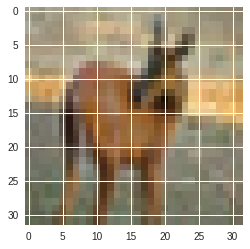

Predicted label: 1 and actual label: 1


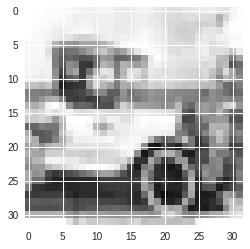

Predicted label: 1 and actual label: 9


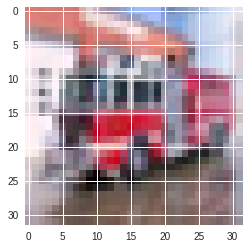

Predicted label: 7 and actual label: 5


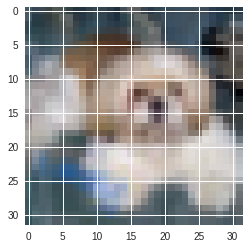

Predicted label: 0 and actual label: 4


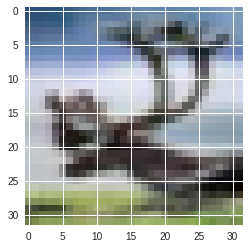

Predicted label: 6 and actual label: 6


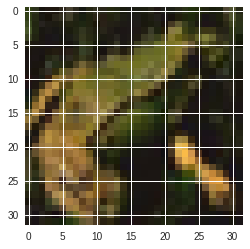

Predicted label: 7 and actual label: 5


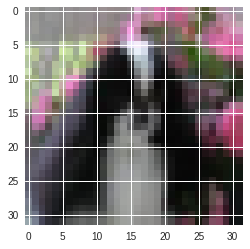

Predicted label: 2 and actual label: 6


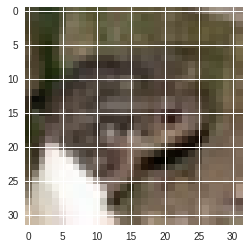

Predicted label: 0 and actual label: 0


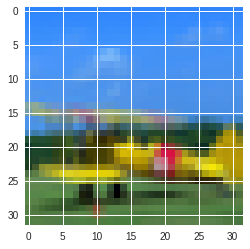

Predicted label: 1 and actual label: 9


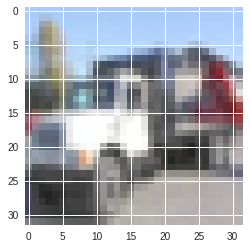

Predicted label: 2 and actual label: 3


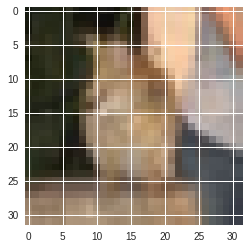

Predicted label: 1 and actual label: 9


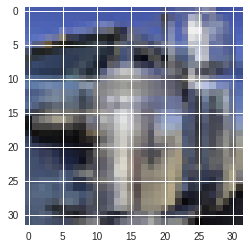

Predicted label: 7 and actual label: 7


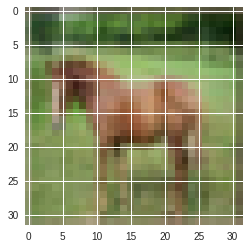

Predicted label: 2 and actual label: 6


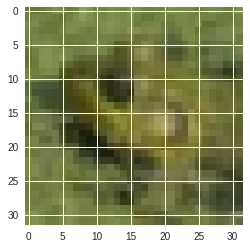

Predicted label: 1 and actual label: 9


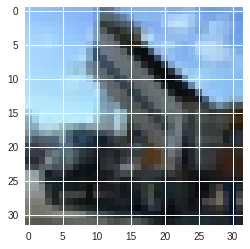

Predicted label: 8 and actual label: 8


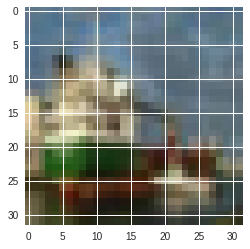

Predicted label: 7 and actual label: 0


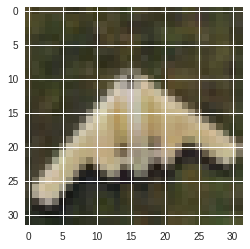

Predicted label: 7 and actual label: 3


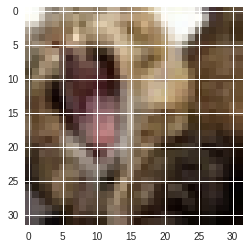

Predicted label: 8 and actual label: 8


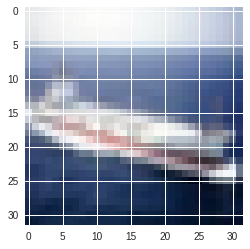

Predicted label: 0 and actual label: 8


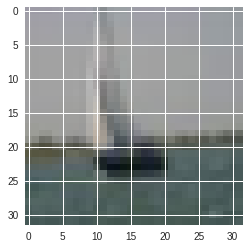

Predicted label: 7 and actual label: 7


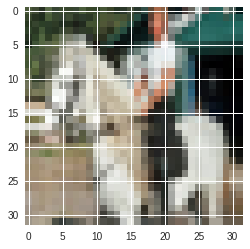

Predicted label: 7 and actual label: 7


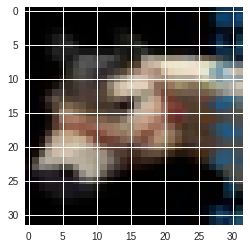

Predicted label: 0 and actual label: 4


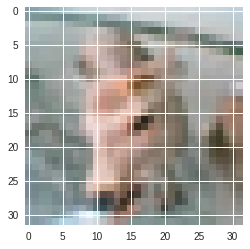

Predicted label: 0 and actual label: 6


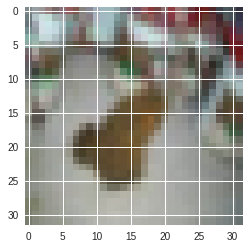

Predicted label: 7 and actual label: 7


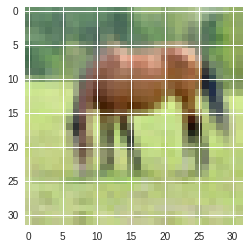

Predicted label: 7 and actual label: 3


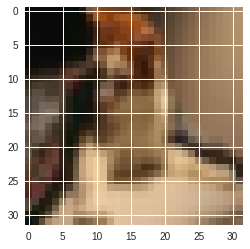

Predicted label: 1 and actual label: 6


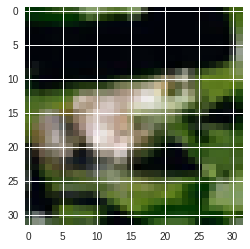

Predicted label: 9 and actual label: 3


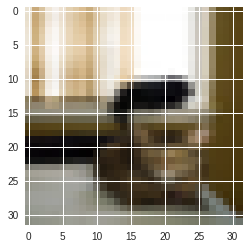

Predicted label: 2 and actual label: 6


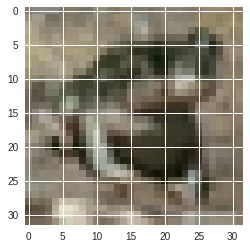

Predicted label: 2 and actual label: 2


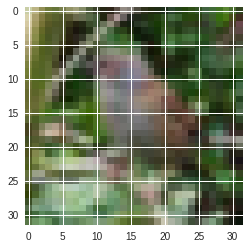

Predicted label: 1 and actual label: 1


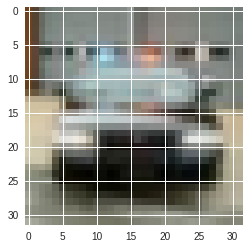

Predicted label: 0 and actual label: 2


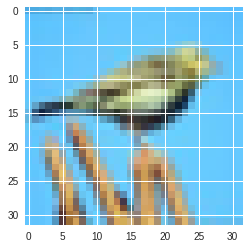

Predicted label: 7 and actual label: 3


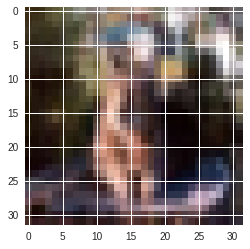

Predicted label: 7 and actual label: 7


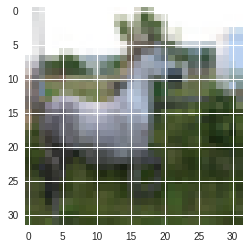

Predicted label: 0 and actual label: 2


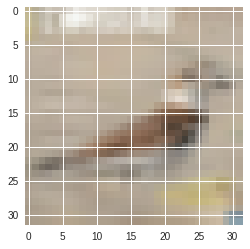

Predicted label: 0 and actual label: 6


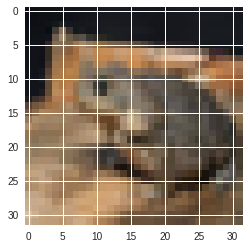

Predicted label: 0 and actual label: 8


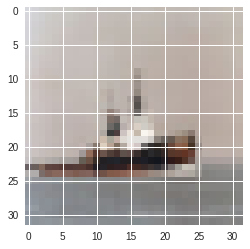

Predicted label: 8 and actual label: 8


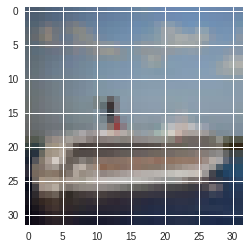

Predicted label: 0 and actual label: 0


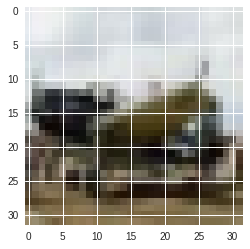

Predicted label: 2 and actual label: 2


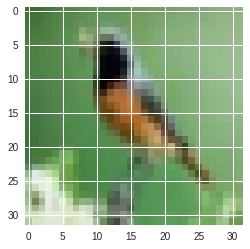

Predicted label: 0 and actual label: 9


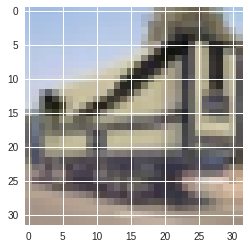

Predicted label: 1 and actual label: 3


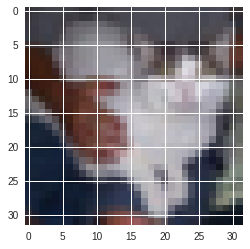

Predicted label: 7 and actual label: 3


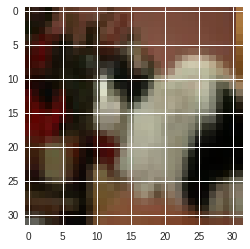

Predicted label: 0 and actual label: 8


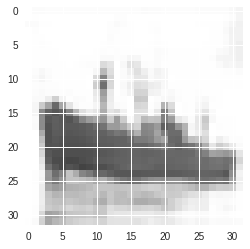

Predicted label: 8 and actual label: 8


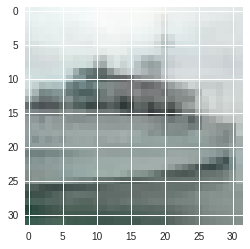

Predicted label: 1 and actual label: 1


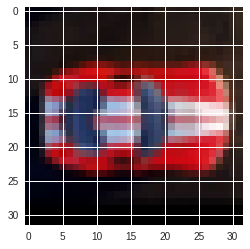

Predicted label: 1 and actual label: 1


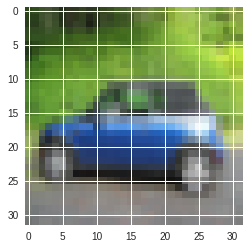

Predicted label: 2 and actual label: 7


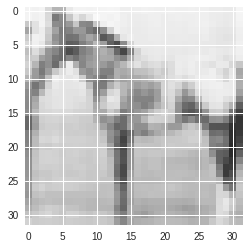

Predicted label: 2 and actual label: 2


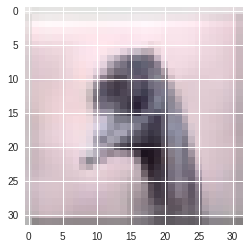

Predicted label: 9 and actual label: 5


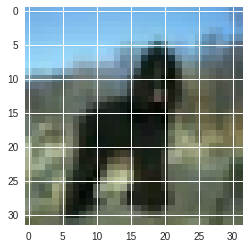

Predicted label: 1 and actual label: 2


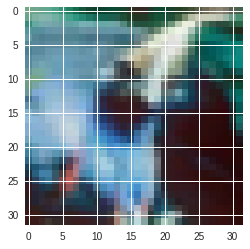

Predicted label: 0 and actual label: 7


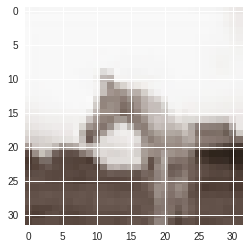

Predicted label: 1 and actual label: 8


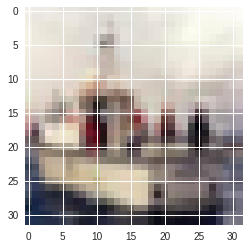

Predicted label: 1 and actual label: 9


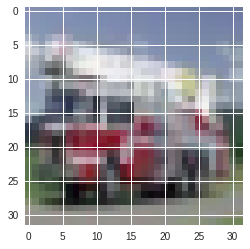

Predicted label: 0 and actual label: 0


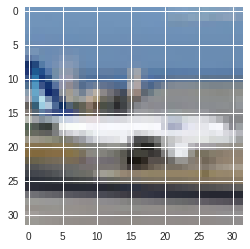

Predicted label: 2 and actual label: 3


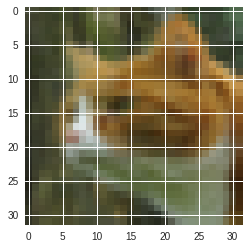

Predicted label: 8 and actual label: 8


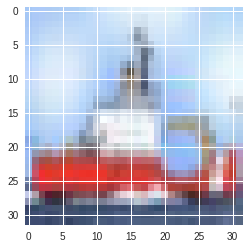

Predicted label: 6 and actual label: 6


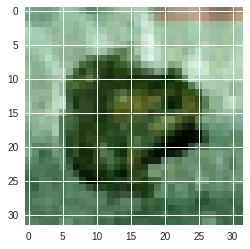

Predicted label: 7 and actual label: 4


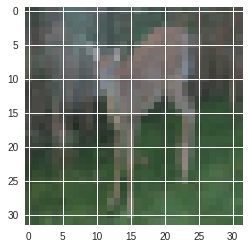

Predicted label: 7 and actual label: 6


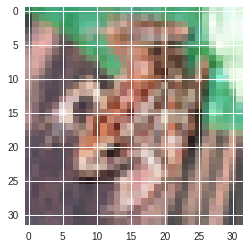

Predicted label: 0 and actual label: 6


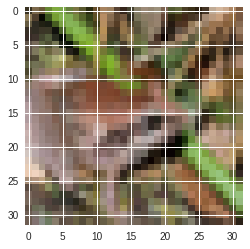

Predicted label: 0 and actual label: 0


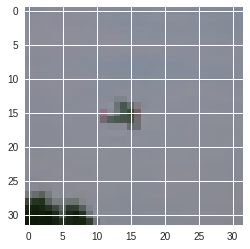

Predicted label: 0 and actual label: 0


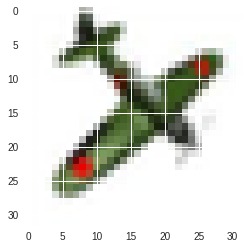

Predicted label: 2 and actual label: 7


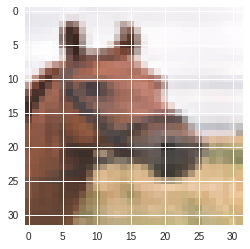

Predicted label: 4 and actual label: 4


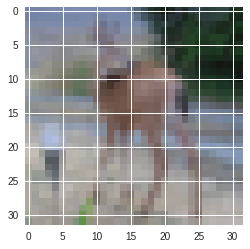

Predicted label: 7 and actual label: 5


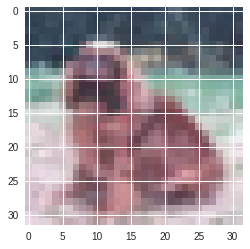

Predicted label: 7 and actual label: 6


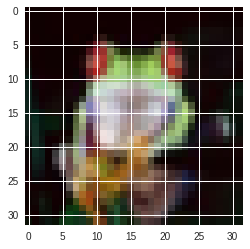

Predicted label: 6 and actual label: 3


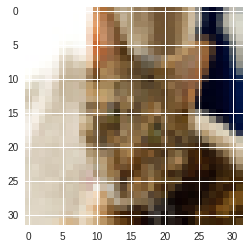

Predicted label: 1 and actual label: 1


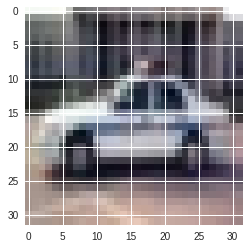

Predicted label: 1 and actual label: 1


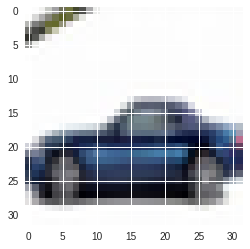

Predicted label: 0 and actual label: 3


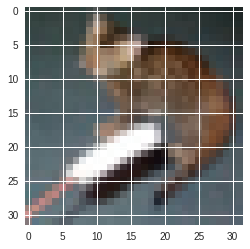

Predicted label: 6 and actual label: 6


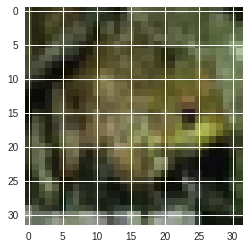

Predicted label: 8 and actual label: 8


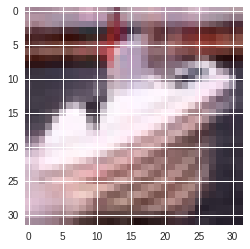

Predicted label: 7 and actual label: 7


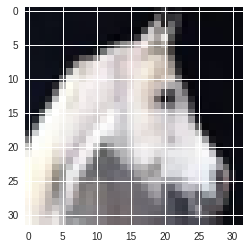

Predicted label: 6 and actual label: 4


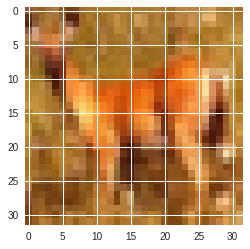

Predicted label: 0 and actual label: 0


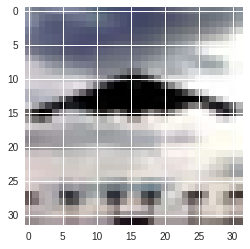

Predicted label: 0 and actual label: 6


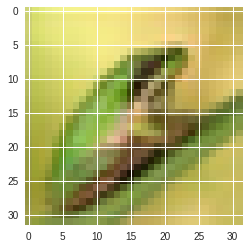

Predicted label: 2 and actual label: 2


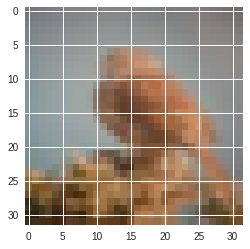

Predicted label: 1 and actual label: 1


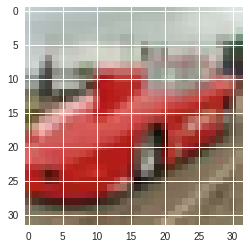

Predicted label: 1 and actual label: 3


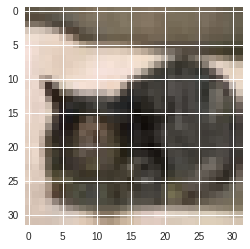

Predicted label: 0 and actual label: 0


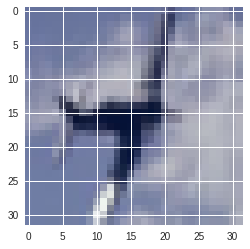

Predicted label: 0 and actual label: 4


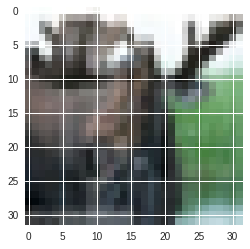

Predicted label: 6 and actual label: 2


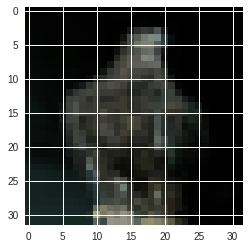

Predicted label: 7 and actual label: 7


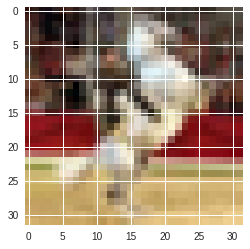

Predicted label: 8 and actual label: 8


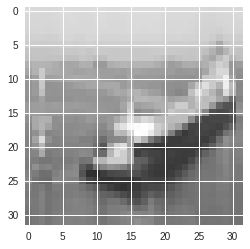

Predicted label: 0 and actual label: 3


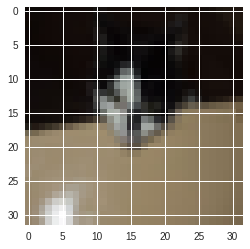

Predicted label: 1 and actual label: 1


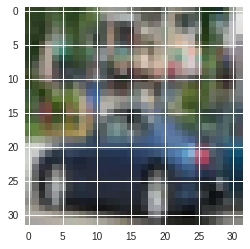

Predicted label: 0 and actual label: 2


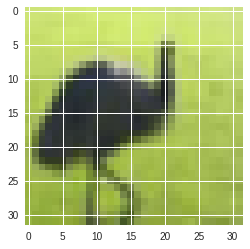

Predicted label: 1 and actual label: 8


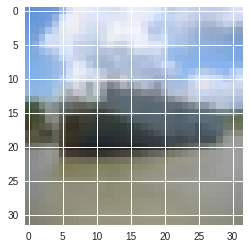

Predicted label: 0 and actual label: 0


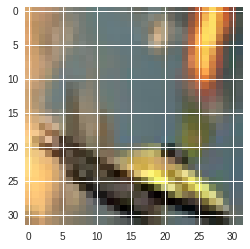

Predicted label: 0 and actual label: 8


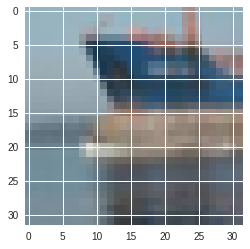

Predicted label: 7 and actual label: 3


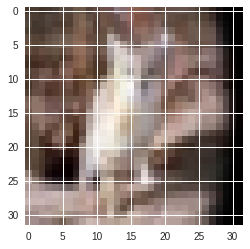

In [0]:

################################################################################
#
# DISPLAY
#
################################################################################

# create a session
session = tf.Session()

# initialize global variables
session.run(tf.global_variables_initializer())

# initialize the test iterator
session.run(iterator_init_test)

# cycle through a few batches
for batch_index in range(1):
    
    # generate data and labels
    data_batch, labels_batch = session.run([data, labels])
    
    # normalize to [0, 1]
    data_batch = ((data_batch*data_std) + data_mean)/255.0;
    
    # convert the final saved predictions to labels
    row_start          = batch_index*TRAINING_BATCH_SIZE
    row_end            = (batch_index + 1)*TRAINING_BATCH_SIZE
    predictions_labels = np.argmax(predictions_test[row_start:row_end, :], axis=1)
    
    # cycle through the images in the batch
    for image_index in range(TRAINING_BATCH_SIZE):
        
        # display the predicted label, actual label and image
        print('Predicted label: {0:1d} and actual label: {1:1d}'.format(predictions_labels[image_index], labels_batch[image_index]))
        plt.imshow(data_batch[image_index, :, :, :])
        plt.show()

# close the session
session.close()

In [0]:
################################################################################
#
# MODEL - Inception V4 modified
#
################################################################################

# inception model (3-4 91.26 %)
@autograph.convert()
def model_inception(data, train_state, inception_a_blocks, inception_b_blocks, num_classes):
    
    # data
    # TRAINING_BATCH_SIZE x rows x cols x channels

    # tail
    fm = tf.layers.conv2d(data, 384, (190, 190), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)

    # endoder - INCEPTION A block x (inception_a_blocks)
    # input:  384 x 35 x 35
    # output: 384 x 35 x 35
    for _ in range(inception_a_blocks):
        # BRANCH 0
        #     avg pooling 384 x 384 x 3 x 3
        #     filter: 96 x 384 x 1 x 1
        branch_0 = tf.layers.average_pooling2d(fm, (3, 3), strides=(1,1), padding='same', data_format='channels_last')
        branch_0 = tf.layers.conv2d(branch_0, 96, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        # BRANCH 1
        #     filter: 96 x 384 x 1 x 1
        branch_1 = tf.layers.conv2d(fm, 96, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        # BRANCH 2
        #     filter: 64 x 384 x 1 x 1
        #     filter: 96 x 64 x 3 x 3
        branch_2 = tf.layers.conv2d(fm, 64, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        branch_2 = tf.layers.conv2d(branch_2, 96, (3,3), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        # BRANCH 3
        #     filter: 64 x 384 x 1 x 1
        #     filter: 96 x 64 x 3 x 3
        #     filter: 96 x 96 x 3 x 3
        branch_3 = tf.layers.conv2d(fm, 64, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        branch_3 = tf.layers.conv2d(branch_3, 96, (3,3), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        branch_3 = tf.layers.conv2d(branch_3, 96, (3,3), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        # output: 384 x 35 x 35
        fm = tf.concat([branch_0, branch_1, branch_2, branch_3], axis=3)
        
    # endoder - REDUCTION A block
    # input:  384 x 35 x 35
    # output: 1024 x 17 x 17
    # BRANCH 0
    #     max pooling 384 X 384 x 3 x 3 / 2
    branch_0 = tf.layers.max_pooling2d(fm, (3, 3), strides=(2,2), padding='same', data_format='channels_last')
    # BRANCH 1
    #     max pooling 384 X 384 x 3 x 3 / 2
    branch_1 = tf.layers.max_pooling2d(fm, (3, 3), strides=(2,2), padding='same', data_format='channels_last')
    # BRANCH 2
    #     filter: 192 x 384 x 1 x 1
    #     filter: 224 x 192 x 3 x 3
    #     filter: 256 x 224 x 3 x 3 / 2
    branch_2 = tf.layers.conv2d(fm, 192, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    branch_2 = tf.layers.conv2d(branch_2, 224, (3,3), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    branch_2 = tf.layers.conv2d(branch_2, 256, (3,3), strides=(2,2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    # output: 1024 x 17 x 17
    fm = tf.concat([branch_0, branch_1, branch_2], axis=3)
    
    # endoder - INCEPTION B block x (inception_b_blocks)
    # input:  1024 x 17 x 17
    # output: 1536 x 17 x 17
    for _ in range(inception_b_blocks):
        # BRANCH 0
        #     avg pooling 1024 X 1024 x 3 x 3
        #     filter: 128 x 1024 x 1 x 1
        branch_0 = tf.layers.average_pooling2d(fm, (3, 3), strides=(1,1), padding='same', data_format='channels_last')
        branch_0 = tf.layers.conv2d(branch_0, 128, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        # BRANCH 1
        #     filter: 384 x 1024 x 1 x 1
        branch_1 = tf.layers.conv2d(fm, 384, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        # BRANCH 2
        #     filter: 192 x 1024 x 1 x 1
        #     filter: 224 x 192 x 1 x 7
        #     filter: 256 x 224 x 1 x 7
        branch_2 = tf.layers.conv2d(fm, 192, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        branch_2 = tf.layers.conv2d(branch_2, 224, (1,7), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        branch_2 = tf.layers.conv2d(branch_2, 256, (1,7), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        # BRANCH 3
        #     filter: 192 x 1024 x 1 x 1
        #     filter: 192 x 192 x 1 x 7
        #     filter: 224 x 192 x 7 x 1
        #     filter: 224 x 224 x 1 x 7
        #     filter: 256 x 224 x 7 x 1
        branch_3 = tf.layers.conv2d(fm, 192, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        branch_3 = tf.layers.conv2d(branch_3, 192, (1,7), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        branch_3 = tf.layers.conv2d(branch_3, 224, (7,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        branch_3 = tf.layers.conv2d(branch_3, 224, (1,7), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        branch_3 = tf.layers.conv2d(branch_3, 256, (7,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
        # output: 1536 x 17 x 17
        fm = tf.concat([branch_0, branch_1, branch_2, branch_3], axis=3)
    
    # endoder - REDUCTION B block
    # input:  1536 x 17 x 17
    # output: 1536 x 8 x 8
    # BRANCH 0
    #     max pooling 1024 X 1536 x 3 x 3 / 2
    branch_0 = tf.layers.max_pooling2d(fm, (3, 3), strides=(2,2), padding='same', data_format='channels_last')
    # BRANCH 1
    #     filter: 192 x 1024 x 1 x 1
    #     filter: 192 x 192 x 3 x 3 / 2
    branch_1 = tf.layers.max_pooling2d(fm, (3, 3), strides=(2,2), padding='same', data_format='channels_last')
    branch_1 = tf.layers.conv2d(branch_1, 224, (3,3), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    # BRANCH 2
    #     filter: 256 x 1536 x 1 x 1
    #     filter: 256 x 256 x 1 x 7
    #     filter: 320 x 256 x 7 x 1
    #     filter: 320 x 320 x 3 x 3 / 2
    branch_2 = tf.layers.conv2d(fm, 256, (1,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    branch_2 = tf.layers.conv2d(branch_2, 256, (1,7), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    branch_2 = tf.layers.conv2d(branch_2, 320, (7,1), strides=(1,1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    branch_2 = tf.layers.conv2d(branch_2, 320, (3,3), strides=(2,2), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=None, use_bias=False)
    # output: 1536 x 8 x 8
    fm = tf.concat([branch_0, branch_1, branch_2], axis=3)
    
    
    # decoder
    # predictions.shape = TRAINING_BATCH_SIZE x num_classes
    fm = tf.layers.average_pooling2d(fm, 8, strides=(1, 1), padding='same', data_format='channels_last')
    fm = tf.layers.dropout(fm, 0.8)
    fm = tf.layers.flatten(fm)
    predictions = tf.layers.dense(fm, num_classes, activation=None, use_bias=True)
    
    # return
    return predictions


In [0]:
import time
start_time = time.time()

################################################################################
#
# TRAINING INCEPTION v4 modified
#
################################################################################

# state
train_state = tf.placeholder(tf.bool, name='train_state')

# data
num_train         = len(data_train)
num_test          = len(data_test)
num_batches_train = int(num_train/TRAINING_BATCH_SIZE)
num_batches_test  = int(num_test/TRAINING_BATCH_SIZE)

# display
# print(num_train)
# print(num_test)
# print(num_batches_train)
# print(num_batches_test)

# model
# predictions      = model_sequential(data, train_state, DATA_NUM_CLASSES)
# predictions      = model_sequential_bn(data, train_state, DATA_NUM_CLASSES)
# predictions      = model_resnet(data, train_state, MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS, DATA_NUM_CLASSES)
#predictions      = model_resnet_halfwide(data, train_state, MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS, DATA_NUM_CLASSES)
predictions      = model_inception(data, train_state, INCEPTION_A_BLOCKS, INCEPTION_B_BLOCKS, DATA_NUM_CLASSES)


predictions_test = np.zeros((num_test, DATA_NUM_CLASSES), dtype=np.float32)

# accuracy
accuracy = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(predictions, 1), tf.cast(labels, tf.int64)), tf.float32))

# loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=predictions)

# optimizer
global_step   = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(TRAINING_LR_INITIAL, global_step, TRAINING_LR_EPOCHS*num_batches_train, TRAINING_LR_SCALE, staircase=TRAINING_LR_STAIRCASE)
update_ops    = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    # optimizer = tf.train.MomentumOptimizer(learning_rate, TRAINING_MOMENTUM, use_nesterov=True).minimize(loss, global_step=global_step)

# saver
# saver = tf.train.Saver(max_to_keep=TRAINING_MAX_CHECKPOINTS)

# create a session
session = tf.Session()
    
# initialize global variables
session.run(tf.global_variables_initializer())

# cycle through the epochs
for epoch_index in range(TRAINING_NUM_EPOCHS):
    
    # train
    # initialize the iterator to the training dataset
    # cycle through the training batches
    # example, encoder, decoder, error, gradient computation and update
    session.run(iterator_init_train)
    for batch_index in range(num_batches_train):
        session.run(optimizer, feed_dict={train_state: True})

    # validate
    # initialize the iterator to the testing dataset
    # reset the accuracy statistics
    # cycle through the testing batches
    # example, encoder, decoder, accuracy
    session.run(iterator_init_test)
    num_correct = 0
    for batch_index in range(num_batches_test):
        num_correct_batch, predictions_batch    = session.run([accuracy, predictions], feed_dict={train_state: False})
        num_correct                            += num_correct_batch
        row_start                               = batch_index*TRAINING_BATCH_SIZE
        row_end                                 = (batch_index + 1)*TRAINING_BATCH_SIZE
        predictions_test[row_start:row_end, :]  = predictions_batch

    # display
    print('Epoch {0:3d}: top 1 accuracy on the test set is {1:5.2f} %'.format(epoch_index, (100.0*num_correct)/(TRAINING_BATCH_SIZE*num_batches_test)))

    # save
    # saver.save(session, TRAINING_CHECKPOINT_FILE.format(epoch_index))

# close the session
session.close()

print("TRAINING RESNET v2--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.cast instead.
